In [1]:
import sys
import os
import cv2
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
from numpy import pi, matmul,sqrt,dot,array,zeros,cos,sin,pi,arccos
from torch.utils.data import DataLoader
from func import OR,heatplot,misorientation,mat2plot, match,imgshow,calpoint,L2,L1,ipfread
from Class import Exp,Data,Cluster
import torch.nn.functional as F
import matplotlib.patches as patches

class Dataset(torch.utils.data.Dataset):
    def __init__(self,bef,im,target):
        self.bef=bef
        self.im=im
        self.target=target
    def __getitem__(self,index):
        X=self.bef[index]
        Y=self.target[index]
        im=self.im[index]
        return torch.tensor(X,dtype=torch.float32),torch.tensor(Y,dtype=torch.long),im
    def __len__(self):
        return len(self.bef)
def negsample(corner):
    mat=np.zeros([500,500])
    for (i,j) in corner:
        for k in range(max(0,i-49),min(500,i+50)):
            for l in range(max(0,j-49),min(500,j+50)):
                mat[k,l]=1
    cand = []
    for i in range(451):
        for j in range(451):
            if not mat[i][j]:
                cand.append([i,j])
    return random.sample(cand,len(corner))


In [2]:
def create_dataset(root="data/train/",feature=["orient","MAD"]):
    corner=torch.load("data/corner.pkl")
    bef=[]
    im=[]
    target=[]
    h=w=50
    for date in os.listdir(root):
        path=root+date+"/before/"
        data=Data(path)
        data.data["orient"]=data.data["orient"].reshape(data.h,data.w,-1)
        for (i,j) in corner[date]:
            im.append(ipfread(path)[i:i+h,j:j+w]/255.)
            app=[]
            for ele in feature:
                if ele=="orient":
                    app.append(data.data[ele][i:i+h,j:j+w])
                else:
                    app.append(data.data[ele][i:i+h,j:j+w,np.newaxis])
            bef.append(np.concatenate(app,axis=2))
            target.append(0)
        for (i,j) in negsample(corner[date]):
            im.append(ipfread(path)[i:i+h,j:j+w]/255.)
            app=[]
            for ele in feature:
                if ele=="orient":
                    app.append(data.data[ele][i:i+h,j:j+w])
                else:
                    app.append(data.data[ele][i:i+h,j:j+w,np.newaxis])
            bef.append(np.concatenate(app,axis=2))
            target.append(1)
        
    bef=np.transpose(np.array(bef),(0,3,1,2))
    im=np.array(im)
    target=np.array(target)
    return Dataset(bef,im,target)
train=create_dataset("data/train/")
test=create_dataset("data/test/")

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.relu = nn.ReLU() # activation
        self.maxpool = nn.MaxPool2d(kernel_size=2) #output_shape=(16,24,24)
        self.cnn1 = nn.Conv2d(in_channels=10, out_channels=12, kernel_size=3, stride=1, padding=0) #output_shape=(16,48,48)
        self.cnn2 = nn.Conv2d(in_channels=12, out_channels=18, kernel_size=3, stride=1, padding=1) #output_shape=(32,22,22
        self.cnn3 = nn.Conv2d(in_channels=18, out_channels=24, kernel_size=3, stride=1, padding=0) #output_shape=(32,22,22
        self.fc1 = nn.Linear(24 * 5 * 5, 2) 
        self.softmax = nn.Softmax(1)
    def forward(self, x):
        # Convolution 1 50
        out = self.cnn1(x) # 48
        out = self.relu(out)
        out = self.maxpool(out) #24
        out = self.cnn2(out) #24
        out = self.relu(out) 
        out = self.maxpool(out) #12
        out = self.cnn3(out) #10
        out = self.relu(out)
        out = self.maxpool(out) #5
        out = out.view(out.size(0), -1)
        # Linear function (readout)
        out = self.fc1(out)
        out = self.softmax(out)
        return out

In [4]:
train_loader= DataLoader(train, batch_size=64, shuffle=True,  num_workers=0, drop_last=True )
test_loader= DataLoader(test, batch_size=64, shuffle=True,  num_workers=0,  drop_last=False )

In [5]:
model = CNN()
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
max_acc = 0
epoch = 1000
for ep in range(epoch):
    for batch_ndx, sample in enumerate(train_loader):
        optimizer.zero_grad()
        X,Y,_= sample
        output=model(X)
        loss = Loss(output,Y)
        loss.backward()
        optimizer.step()
#         print("train ",ep,loss.item())
    model.eval()
    cum=0
    loss=0
    for batch_ndx, sample in enumerate(test_loader):
        X,Y,_= sample
        output=model(X)
        loss+=Loss(output,Y)
        predict = torch.max(output, 1)[1]
        cum+=np.sum((Y == predict).cpu().numpy())
    acc=cum/len(test)
    if acc>max_acc:
        max_acc=acc
        min_loss = loss.item()
        print(ep,min_loss)
        print("acc= ",cum,"/",len(test))
        torch.save(model,"model/%.3f"%(acc))
        
    

0 1.3870737552642822
acc=  52 / 102
1 1.3861339092254639
acc=  54 / 102


/home/kisaki/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


7 1.3848265409469604
acc=  55 / 102
8 1.3854844570159912
acc=  56 / 102
50 1.355980634689331
acc=  57 / 102
55 1.356072187423706
acc=  60 / 102
56 1.3446459770202637
acc=  61 / 102
57 1.3443913459777832
acc=  62 / 102
64 1.3387969732284546
acc=  63 / 102
69 1.3158447742462158
acc=  65 / 102
72 1.3067831993103027
acc=  66 / 102
75 1.2942967414855957
acc=  68 / 102
77 1.2899656295776367
acc=  69 / 102
79 1.2795231342315674
acc=  70 / 102
88 1.262190818786621
acc=  71 / 102
96 1.228257417678833
acc=  72 / 102
100 1.2286694049835205
acc=  75 / 102
101 1.2344470024108887
acc=  76 / 102
112 1.2293109893798828
acc=  78 / 102


In [56]:
corner=torch.load("data/corner.pkl")


In [7]:
model = torch.load("model/0.765")
for param in model.parameters():
    param.requires_grad = False

tensor(0)
tensor([[0.6959, 0.3041]], grad_fn=<SoftmaxBackward>)


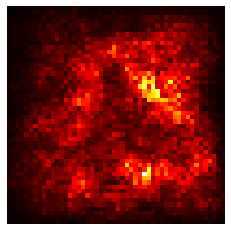

In [51]:
index=1
X=test[index][0].unsqueeze(0)
print(test[index][1])

# we would run the model in evaluation mode
model.eval()

# we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
X.requires_grad_()

'''
forward pass through the model to get the scores, note that VGG-19 model doesn't perform softmax at the end
and we also don't need softmax, we need scores, so that's perfect for us.
'''

scores = model(X)
print(scores)
# Get the index corresponding to the maximum score and the maximum score itself.
score_max_index = scores.argmax()
score_max = scores[0,score_max_index]

'''
backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
score_max with respect to nodes in the computation graph
'''
score_max.backward()

'''
Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
across all colour channels.
'''
saliency, _ = torch.max(X.grad.data.abs(),dim=1)

# code to plot the saliency map as a heatmap
plt.imshow(saliency[0], cmap=plt.cm.hot)
plt.axis('off')
plt.show()

In [53]:
cv2.imwrite("output/t1.png",(255*test[index][2][:,:,6:]).astype("int"))

True

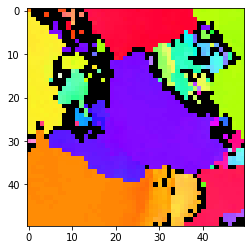

In [58]:
plt.imshow((255*test[index][2][:,:,6:]).astype("int"))